In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install pdpbox
    !pip install shap
    
else:    
    DATA_PATH = '../data/'

In [85]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBClassifier
import pandas as pd

In [54]:
def wrangle(filepath):
    # Import CSV, set issue date to index
    df = pd.read_csv(filepath,
                     parse_dates=['issue_d'],
                     index_col='issue_d').sort_index()
    
    # Just use 36 month loans
    df = df[df.term == ' 36 months']
    
    # Clean data col names
    df = df.rename(columns=
        {'annual_inc': 'annual_income',
         'fico_range_high': 'credit_score',
         'funded_amnt': 'loan_amount',
         'title': 'loan_purpose'})
    
    # Engineer features
    df['interest_rate'] = df['int_rate'].str.strip('%').astype(float)
    df['monthly_debts'] = df['annual_income'] / 12 * df['dti'] / 100
    
    # Select features for FM
    cols = ['annual_income', 
            'credit_score',
            'interest_rate',
            'loan_amount',
            'loan_purpose',
            'monthly_debts']
    
    df = df[cols]
    
    # Drop rows with NaN values
    df.dropna(inplace=True)

    # Cleaning / engineering features from 'loan_purpose'

    ## Lowercase 'loan_purpose'
    df['loan_purpose'] = df['loan_purpose'].str.lower().str.strip()
    
    ## Add loan purpose OHE
    key_words = ['credit card', 'consolida', 'home', 'medical', 
                 'vacation', 'moving', 'car ', 'personal']
    
    for word in key_words:
        df[f'purpose_{word}'] = df['loan_purpose'].str.contains(word).astype(int)

    # Drop 'loan_purpose' column
    df.drop(columns='loan_purpose', inplace=True)

    # Remove row where salary is > $250,000
    df = df[df['annual_income'] < 250_000]
    
    return df

In [55]:
df = wrangle(DATA_PATH+'lending-club/lending-club-subset.csv')

In [56]:
df.shape

(100310, 13)

In [57]:
df.head()

,annual_income,credit_score,interest_rate,loan_amount,monthly_debts,purpose_credit card,purpose_consolida,purpose_home,purpose_medical,purpose_vacation,purpose_moving,purpose_car,purpose_personal
issue_d,,,,,,,,,,,,,
2007-07-01,20000.0,684.0,10.28,3500.0,25.000000,0,0,0,0,0,0,0,0
2007-07-01,95000.0,774.0,7.43,5000.0,303.208333,0,0,0,0,0,0,0,0
2007-07-01,150000.0,779.0,7.43,5000.0,0.000000,0,0,0,0,0,0,0,0
2007-07-01,200000.0,679.0,10.28,3000.0,0.000000,0,0,0,0,0,0,0,0
2007-08-01,61800.0,749.0,7.75,4000.0,178.190000,0,0,0,0,0,0,0,0


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100310 entries, 2007-07-01 to 2019-03-01
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   annual_income        100310 non-null  float64
 1   credit_score         100310 non-null  float64
 2   interest_rate        100310 non-null  float64
 3   loan_amount          100310 non-null  float64
 4   monthly_debts        100310 non-null  float64
 5   purpose_credit card  100310 non-null  int64  
 6   purpose_consolida    100310 non-null  int64  
 7   purpose_home         100310 non-null  int64  
 8   purpose_medical      100310 non-null  int64  
 9   purpose_vacation     100310 non-null  int64  
 10  purpose_moving       100310 non-null  int64  
 11  purpose_car          100310 non-null  int64  
 12  purpose_personal     100310 non-null  int64  
dtypes: float64(5), int64(8)
memory usage: 10.7 MB


<AxesSubplot:>

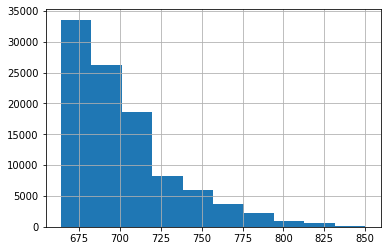

In [59]:
df['credit_score'].hist()

<AxesSubplot:>

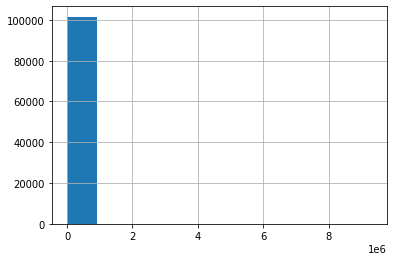

In [18]:
df['annual_income'].hist()

# Not great Lotsa outliers here

In [60]:
df.describe()

,annual_income,credit_score,interest_rate,loan_amount,monthly_debts,purpose_credit card,purpose_consolida,purpose_home,purpose_medical,purpose_vacation,purpose_moving,purpose_car,purpose_personal
count,100310.000000,100310.000000,100310.000000,100310.000000,100310.000000,100310.000000,100310.000000,100310.000000,100310.000000,100310.000000,100310.000000,100310.000000,100310.000000
mean,71005.223587,701.278028,11.650195,12438.315970,997.599245,0.222590,0.523657,0.065098,0.013219,0.007786,0.007168,0.011514,0.004815
std,37839.563936,32.719370,3.617225,8042.930365,651.771473,0.415987,0.499443,0.246700,0.114212,0.087894,0.084359,0.106686,0.069224
min,20.000000,664.000000,5.310000,500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,45000.000000,674.000000,8.490000,6300.000000,543.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,62000.000000,694.000000,11.490000,10000.000000,866.250000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,89197.500000,719.000000,13.990000,16000.000000,1305.768750,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,249996.000000,850.000000,28.800000,40000.000000,6345.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<AxesSubplot:>

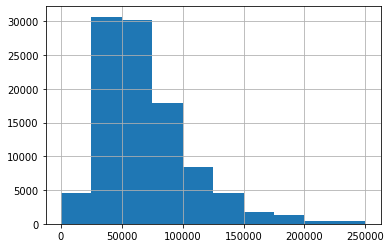

In [61]:
df['annual_income'].hist()

# After making some adjustments to income, new distribution - much better!

In [63]:
# Split data

target = 'interest_rate'
y = df[target]
X = df.drop(columns=target)

In [68]:
# The index is sorted, so we can see the earliest loans were in July 2007, and the 
# last loans are from March 2019

df.index[:15]

DatetimeIndex(['2007-07-01', '2007-07-01', '2007-07-01', '2007-07-01',
               '2007-08-01', '2007-08-01', '2007-08-01', '2007-09-01',
               '2007-09-01', '2007-10-01', '2007-10-01', '2007-10-01',
               '2007-10-01', '2007-10-01', '2007-10-01'],
              dtype='datetime64[ns]', name='issue_d', freq=None)

In [66]:
df.index[-15:]

DatetimeIndex(['2019-03-01', '2019-03-01', '2019-03-01', '2019-03-01',
               '2019-03-01', '2019-03-01', '2019-03-01', '2019-03-01',
               '2019-03-01', '2019-03-01', '2019-03-01', '2019-03-01',
               '2019-03-01', '2019-03-01', '2019-03-01'],
              dtype='datetime64[ns]', name='issue_d', freq=None)

In [74]:
# Split the dataset into training and test sets

cutoff = int(len(X) * 0.8)
X_train, y_train = X.iloc[:cutoff], y.iloc[:cutoff]
X_val, y_val = X.iloc[cutoff:], y.iloc[cutoff:]

In [80]:
print(len(y_train))

80248


In [83]:
# Establish as baseline (Regression Model, so will use MAE)

y_pred = [y_train.mean()] * len(y_train)
print('Mean Loan Interest Rate: {:.4f}'.format(y_train.mean()))
print('Baseline MAE: {:.4f}'.format(mean_absolute_error(y_train, y_pred)))

Mean Loan Interest Rate: 11.5702
Baseline MAE: 2.8925


In [87]:
# Regression Model Selections - LinearRegressor, RandomForestClassifier, XGBRegressor

model_boost = XGBClassifier(n_estimators=20, random_state=42)
model_boost.fit(X_train, y_train)

model_forest = RandomForestRegressor(n_estimators=20, random_state=42)
model_forest.fit(X_train, y_train)

RandomForestRegressor(n_estimators=20, random_state=42)

In [91]:
# Check Metrics

for model in [model_boost, model_forest]:
    print(type(model)),
    print('Training MAE: {:.4f}'.format(mean_absolute_error(y_train, model.predict(X_train))))
    print('Test MAE: {:.4f}'.format(mean_absolute_error(y_val, model.predict(X_val))))
    print()

<class 'xgboost.sklearn.XGBClassifier'>
Training MAE: 2.4939
Test MAE: 3.1886
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
Training MAE: 0.9023
Test MAE: 2.7708
